In [11]:
import sys
import import_ipynb
import numpy as np
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as assembly, gaussian_quadrature, master_domain
    from fem_pos_processing import graph_results, fem_analysis
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

# `setTypeProblem()`

In [12]:
def setTypeProblem(FINITE_ELEMENT, h):
    # Create mesh using gmsh
    BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
    MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]
    
    # Create mesh Structure Data from gmsh
    mesh_data = ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, auto_save=False)
    
    # Get FEM solution
    Sg, fg, Mg, _, _ = assembly.global_matrices(FINITE_ELEMENT, mesh_data, formulation='edge')
    Sg, fg = assembly.apply_simple_dirichlet_vectorial(Sg, fg, mesh_data)
    curl_uh = spsolve((Sg+Mg).tocsr(), fg.toarray())
    curl_uh = {key+1: value for key, value in enumerate(curl_uh)}
    
    return curl_uh, mesh_data

# Convergence Analysis

In [13]:
element_types = [('Triangle', 1)]
u_f_gradu = lambda x, y: ps.set_analytical_solution(x, y)
mesh_sizes = [1 / (2**i) for i in range(0, 4)]

# Inicialização dos dicionários para armazenar erros acumulados para cada tipo de elemento
errors_l2 = {et: [] for et in element_types}

for h in mesh_sizes:  
    for FINITE_ELEMENT in element_types:  
        # Resolve a solução numérica para o tipo de elemento e refinamento de malha
        curl_uh, mesh_data = setTypeProblem(FINITE_ELEMENT, h)  
        
        # Calcula o erro L2, o erro de energia e a energia total
        # ---------------------------------------------- #    

        # Inicializa o somatório do erro L2 para este tipo e refinamento
        error_L2_sum = 0.0  # Reinicia o somatório do erro L2 para este tipo e refinamento

        # # Coeficientes analíticos
        # curl_u = ps.curl_u_at_domain(mesh_data)

         # Get the Gauss points and weights
        gauss_points, gauss_weights = gaussian_quadrature.gauss_data(FINITE_ELEMENT)

        for key, cell in mesh_data['cell'].items():
            # Get the global coordinates of the nodes
            aie = [mesh_data['nodes'][node]['xg'] for node in cell['conn_sorted']]

            # Calcula o jacobiano e seu determinante
            Je = assembly.vectorial_jacobian(mesh_data, cell) 
            Jdet = np.abs(np.linalg.det(Je))        
            JinvT = np.linalg.inv(Je).T

            # # Solução numérica nos nós do elemento
            # uhe = [curl_uh[node] for node in cell['conn_sorted']]

            # Integração numérica com a regra de quadratura de Gauss    
            for i, (xik, wk) in enumerate(zip(gauss_points, gauss_weights)):
                # Mapeamento isoparamétrico de coordenadas locais (xik) para coordenadas globais (x, y)
                xge, yge = assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, aie, xik)

                # Calcula a solução vetorial exata no ponto de Gauss
                u_at_xik = ps.set_analytical_solution(xge, yge)[0]
                print("u_at_xik: \n", u_at_xik)

                # Função de forma vetorial no ponto de Gauss    
                phi_hat = master_domain.shape_functions_n0(*xik)

                # Interpolação dos potenciais vetoriais em cada célula
                uh_at_xik = 0
                for i, edge in enumerate(cell['conn_edge']):
                    uh_at_xik += curl_uh[edge] * (JinvT @ phi_hat[i])
                print("uh_at_xik: \n", uh_at_xik)

                # Calcula o erro quadrático L2 no ponto de Gauss
                error_squared = (np.linalg.norm(u_at_xik) - np.linalg.norm(uh_at_xik)) ** 2
                print("error_squared: ", error_squared)
                print("#---------#")

                # Acumula os erros L2 e de energia
                error_L2_sum += wk * error_squared * Jdet
        
        l2 = np.sqrt(error_L2_sum)

        # ---------------------------------------------- #
        # Acumula os erros nos dicionários correspondentes
        errors_l2[FINITE_ELEMENT].append(l2)


u_at_xik: 
 [[-0.68301271]
 [ 0.18301269]]
uh_at_xik: 
 [[0.03747773+0.j]
 [0.03190522+0.j]]
error_squared:  0.4328161571858855
#---------#
u_at_xik: 
 [[-0.23607715]
 [ 0.75952671]]
uh_at_xik: 
 [[0.07320353+0.j]
 [0.04721627+0.j]]
error_squared:  0.5016322201763301
#---------#
u_at_xik: 
 [[-0.429841  ]
 [-0.24333657]]
uh_at_xik: 
 [[0.01195931+0.j]
 [0.04721627+0.j]]
error_squared:  0.19823147345610448
#---------#
u_at_xik: 
 [[-0.98902899]
 [ 0.00657487]]
uh_at_xik: 
 [[0.02727037+0.j]
 [0.00128311+0.j]]
error_squared:  0.9249636646517694
#---------#
u_at_xik: 
 [[-0.51353683]
 [-0.2006785 ]]
uh_at_xik: 
 [[-0.02311823+0.j]
 [ 0.00593552+0.j]]
error_squared:  0.2782421254115224
#---------#
u_at_xik: 
 [[-0.37636781]
 [ 0.21793773]]
uh_at_xik: 
 [[0.08076057+0.j]
 [0.00593552+0.j]]
error_squared:  0.12526992710692242
#---------#
u_at_xik: 
 [[0.24569051]
 [0.55854884]]
uh_at_xik: 
 [[0.05479087+0.j]
 [0.08384461+0.j]]
error_squared:  0.26013829746924433
#---------#
u_at_xik: 
 [[ 0.

# Figure 1: Convergence of the numerical solution for $L_2$ norm of the error

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pos_processing\pictures\convergence_L2.svg


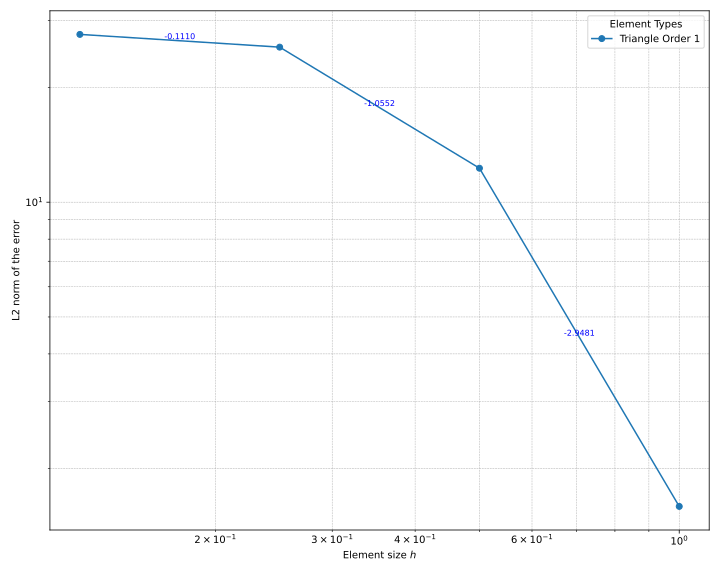

In [14]:
graph_results.plot_convergence(mesh_sizes, errors_l2, type='L2')
display(SVG(filename="pos_processing/pictures/convergence_L2.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.